# Keras implementaion for the Finger Orientaion Model

This model was not used in the paper, we model has some slight variations to the paper model. In contrast to the paper, here we use an RMSprop optimizer with a declining learning rate. Hyperparameter of the optimizer are randomly chosen and are not tuned to achieve the best result.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf


physical_devices = tf.config.experimental.list_physical_devices('GPU')
#assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.set_visible_devices(physical_devices[0], 'GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
tf.__version__

'2.8.0'

In [3]:
%%time
df = pd.read_pickle('./data/all_data.pkl')

CPU times: user 1.69 s, sys: 1.85 s, total: 3.54 s
Wall time: 3.54 s


In [4]:
df.MatrixCroppedSameSize = df.MatrixCroppedSameSize.apply(lambda x: np.multiply(x, 1.0 / 255.0))

if (tf.keras.backend.image_data_format() == 'channels_last'):
    df.MatrixCroppedSameSize = df.MatrixCroppedSameSize.apply(lambda x: x.reshape(22,15,1))
else:
    df.MatrixCroppedSameSize = df.MatrixCroppedSameSize.apply(lambda x: x.reshape(1,22,15))

In [5]:
split = (80, 20)
ps = np.array(sorted(df.Participant.unique()))
num_pt = len(ps)
x1 = (int)(np.floor(len(ps) * split[0] / 100.0))
split_train = ps[:x1]
x2 = (int)(np.floor(len(ps) * split[1] / 100.0))
split_test = ps[x1:]
dfTest = df[df.Participant.isin(split_test)]
dfTrain = df[df.Participant.isin(split_train)]
print("Participants in the train data set %s" % split_train)
print("Participants in the  test data set %s" % split_test)

Participants in the train data set [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Participants in the  test data set [27 28 29 30 31 32 33]


In [6]:
input_shape = dfTest.iloc[0].MatrixCroppedSameSize.shape

print("Shape of the imapge to tain: " + str(input_shape))

Shape of the imapge to tain: (22, 15, 1)


In [7]:
%%time
x_train = np.stack(dfTrain.MatrixCroppedSameSize.values, axis=0)
y_train = np.stack(dfTrain[["Pitch", "Yaw"]].values, axis=0)
x_test  = np.stack(dfTest.MatrixCroppedSameSize.values, axis=0)
y_test  = np.stack(dfTest[["Pitch", "Yaw"]].values, axis=0)

CPU times: user 1.13 s, sys: 142 ms, total: 1.27 s
Wall time: 1.27 s


In [8]:
batch_size = 100

# input image dimensions
img_rows, img_cols = 27, 15

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size=(6, 6),
                                 activation='relu',
                                 padding='same',
                                 bias_initializer=tf.keras.initializers.Constant(value=0.01),
                                 input_shape=input_shape))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))

model.add(tf.keras.layers.Conv2D(72, kernel_size=(6, 6),
                                 activation='relu',
                                 bias_initializer=tf.keras.initializers.Constant(value=0.01),
                                 padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))

model.add(tf.keras.layers.Conv2D(160, kernel_size=(7, 7),
                                 activation='relu',
                                 bias_initializer=tf.keras.initializers.Constant(value=0.01),
                                 padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2000, 
        activation='relu',
        kernel_initializer=tf.keras.initializers.glorot_uniform(),
        bias_initializer=tf.keras.initializers.Constant(value=0.01),
        kernel_regularizer=tf.keras.regularizers.l2(0.15)))

model.add(tf.keras.layers.Dense(2,
        kernel_initializer=tf.keras.initializers.glorot_uniform(),
        bias_initializer=tf.keras.initializers.Constant(value=0.01),
        kernel_regularizer=tf.keras.regularizers.l2(0.15)))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.1)
    
model.summary()

model.compile(loss=tf.keras.losses.mean_squared_error, optimizer=optimizer)

# Function to display the target and prediciton
def testmodel(epoch, logs):
    pred_y = model.predict(
        x_test,
        batch_size=batch_size
    )
    true_y = y_test

    ePitch = np.abs(true_y[:,0] - pred_y[:,0]) 
    eYaw = np.abs(true_y[:,1] - pred_y[:,1])
    ListError = ePitch + eYaw
    ListErrorPitch = ePitch
    ListErrorYaw = eYaw

    diff_true = true_y[:,0] + true_y[:,1]
    diff_pred = pred_y[:,0] + pred_y[:,1]
    RMSE = np.sqrt(np.mean(np.square(np.subtract(diff_pred, diff_true))))
    RMSEPitch = np.sqrt(np.mean(np.square(np.subtract(pred_y[:,0], true_y[:,0]))))
    RMSEYaw   = np.sqrt(np.mean(np.square(np.subtract(pred_y[:,1], true_y[:,1]))))

    print ('\nRMSE: %.2f RMSE-P: %.2f RMSE-Y: %.2f e: %.2f E-P: %.2f E-Y: %.2f std: %.2f std-P: %.2f std-Y: %.2f' %(
              RMSE, RMSEPitch, RMSEYaw,
                ListError.mean(), ListErrorPitch.mean(), ListErrorYaw.mean(),
                ListError.std(), ListErrorPitch.std(), ListErrorYaw.std(),))


# Callback to display the target and prediciton
testcallback = tf.keras.callbacks.LambdaCallback(on_epoch_end=testmodel)

hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=50,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[testcallback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 15, 32)        1184      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 8, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 8, 72)         83016     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 4, 72)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 4, 160)         564640    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 2, 160)        0

2022-05-12 03:58:13.976046: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-12 03:58:14.546815: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30990 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0


Epoch 1/50


2022-05-12 03:58:17.375796: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-05-12 03:58:18.036449: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


3689/3689 [==============================] - ETA: 0s - loss: 1282.1387
RMSE: 52.41 RMSE-P: 15.60 RMSE-Y: 49.83 e: 55.76 E-P: 12.90 E-Y: 42.86 std: 26.85 std-P: 8.78 std-Y: 25.42
3689/3689 [==============================] - 34s 9ms/step - loss: 1282.1387 - val_loss: 1397.4166
Epoch 2/50
3689/3689 [==============================] - ETA: 0s - loss: 1213.2039
RMSE: 50.54 RMSE-P: 15.79 RMSE-Y: 48.15 e: 54.04 E-P: 13.06 E-Y: 40.97 std: 26.80 std-P: 8.87 std-Y: 25.28
3689/3689 [==============================] - 31s 8ms/step - loss: 1213.2039 - val_loss: 1318.4746
Epoch 3/50
3685/3689 [============================>.] - ETA: 0s - loss: 1128.7214
RMSE: 48.49 RMSE-P: 15.68 RMSE-Y: 46.24 e: 51.69 E-P: 12.99 E-Y: 38.70 std: 26.82 std-P: 8.77 std-Y: 25.31
3689/3689 [==============================] - 31s 8ms/step - loss: 1128.6033 - val_loss: 1228.5409
Epoch 4/50
3687/3689 [============================>.] - ETA: 0s - loss: 1054.8794
RMSE: 47.05 RMSE-P: 15.77 RMSE-Y: 44.73 e: 49.95 E-P: 13.09 E-Y: 36.

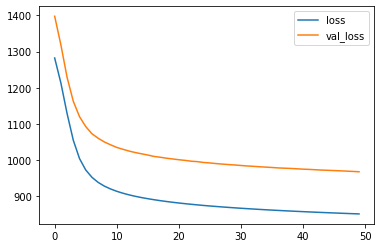

In [19]:
plt.plot(hist.history['loss'], label="loss")
plt.plot(hist.history['val_loss'], label="val_loss")
plt.legend()